In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
ls Data/

DD.mat  ENZYMES.mat  ENZYMES_SYM.mat  MUTAG.mat  NCI109.mat  NCI1.mat  PTC.mat


In [7]:
data = sio.loadmat('Data/ENZYMES_SYM.mat')

In [8]:
type(data['ENZYMES'])

numpy.ndarray

In [9]:
import networkx as nx

In [31]:
ams = (data['ENZYMES']['am'][0])

In [32]:
als = data['ENZYMES']['al'][0]

In [33]:
nls = data['ENZYMES']['nl'][0]

In [91]:
((nls[0]['vecvalues'][0][0][1]))

array([  11.        ,   16.36293528,   40.38      ,   -2.03      ,
          1.777     ,  102.6       ,    2.        ,    7.        ,
          2.        ,    6.        ,    2.        ,    3.        ,
          3.        ,    2.        ,    6.        ,    1.        ,
          8.        ,    2.        ])

In [52]:
labels = data['lenzymes']

In [54]:
labels.shape

(1, 600)

In [57]:
labels = labels[0]

In [133]:
set_labels = set(labels)
set_labels = list(set_labels)
set_labels.sort()

In [337]:
class Graph(object):
    def __init__(self, am, al, vecvalues, value):
        self.am = am
        self.al = al
        self.vecvals = vecvalues[0][0]
        self.val = value[0][0]
        self.size = self.am.shape[0]        
        
        # Computed attributes
        self.lap = self.laplacian()
        self.avgFeat = self.avgFeature()
        self.avgDegs = self.computeAvgDeg()
        self.degs = self.degDistr()
 
    def computeAvgDeg(self):
        avgDeg = 0
        for row in self.am:
            avgDeg += sum(row)
        return avgDeg / float(self.size)
    def degDistr(self):
        distr = []
        for row in self.am:
            distr.append(np.sum(row))
        return distr
    
    def laplacian(self):       
        degs = np.diag(np.sum(self.am, axis=1))
        self.lap = degs - self.am
        return self.lap

    def avgFeature(self):
        avgFeat = np.mean(self.vecvals, axis=0)
        return avgFeat

In [338]:
indices = {}
graphs = {}
for s in set_labels:
    indices[s] = np.where(labels == s)[0]

In [339]:
for s in set_labels:
    inds = indices[s]
    graphs[s] = [Graph(ams[i], als[i], nls[i]['vecvalues'], nls[i]['values']) for i in inds] 

In [340]:
# graphs is a map from label to graph object(holds adj matrix, adj list, vec values, discreate features)

In [341]:
# Compute kernel of just the feature vec dot products
def genKernelMatrix(graphs):
    n = len(graphs)
    kernelMatrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernelMatrix[i, j] = graphs[i]

<class 'matplotlib.axes._subplots.AxesSubplot'>


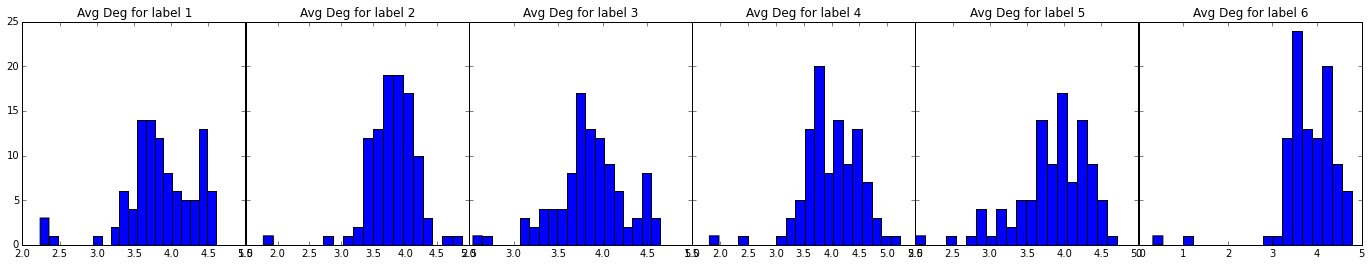

In [342]:
fig, axs = plt.subplots(1,6, figsize=(24, 4), facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
print(type(axs[1]))
for labl in set_labels:
    axs[labl-1].hist([i.avgDegs for i in graphs[labl]], bins=20)
    axs[labl-1].set_title('Avg Deg for label %d' %labl)

In [343]:
print("Average degrees for graphs")
for labl in set_labels:
    avgDegs = [i.avgDegs for i in graphs[labl]]
    #print("Graphs with label %d: %0.2f with std: %0.2f" %(labl, np.mean(avgDegs), np.std(avgDegs)))
    print("Label %d: %0.2f" %(labl, np.mean(avgDegs)))

Average degrees for graphs
Label 1: 3.85
Label 2: 3.79
Label 3: 3.86
Label 4: 3.99
Label 5: 3.84
Label 6: 3.84


In [344]:
# degree distribution
for l in set_labels:
    degrees = {}
    for g in graphs[l]:
        pass

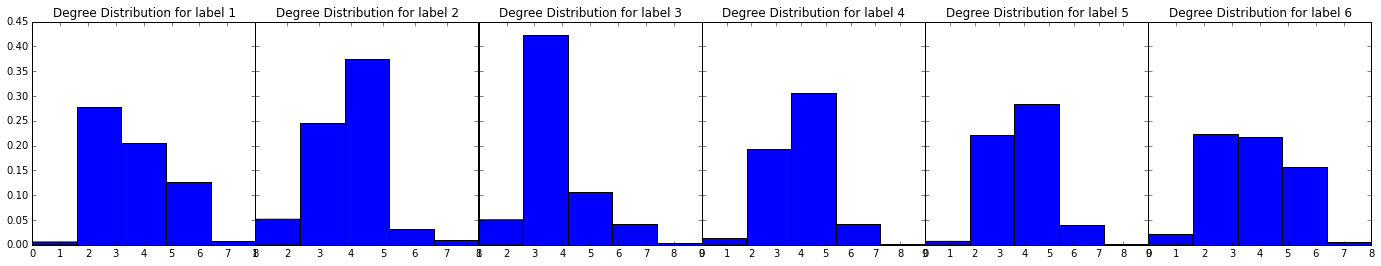

In [345]:
fig, axs = plt.subplots(1,6, figsize=(24, 4), facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for labl in set_labels:
    degDistr = []
    for g in graphs[labl]:
        degDistr += g.degs
    axs[labl-1].hist(degDistr, normed=True, bins=5)
    axs[labl-1].set_title('Degree Distribution for label %d' %labl)

In [346]:
all_graphs = []
for s in set_labels:
    for g in graphs[s]:
        all_graphs.append(g)
        

In [347]:
print(all_graphs[0].vecvals.shape)
print(all_graphs[0].val.shape)

(29, 18)
(29, 1)


In [412]:
# get kernel matrix on entire dataset!
def kernelMatrix(graphs, kernelFunc=None, eps=1):
    '''
        feat = 'vec' or 'val' or 'avg'
        kernelFunc = gaussian, dirac, linear, etc
    '''
    if kernelFunc is None:
        kFunc = lambda x, y: np.dot(x.avgFeat, y.avgFeat)
    elif kernelFunc == 'rbf':
        kFunc = lambda x, y: np.exp(-np.square((np.linalg.norm(x.avgFeat - y.avgFeat))))/(eps**2)
    else:
        kFunc = lambda x, y: np.dot(x.avgFeat, y.avgFeat)
                                    
    kernel = np.zeros((600, 600))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            kernel[i, j] = kFunc(graphs[i], graphs[j])
    return kernel

In [413]:
k = kernelMatrix(all_graphs, kernelFunc='rbf', eps=0.1)

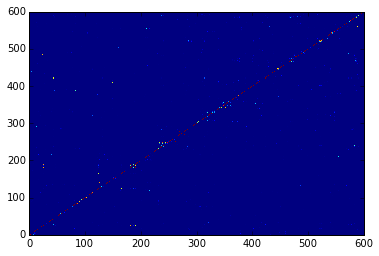

In [414]:
plt.pcolor(k)

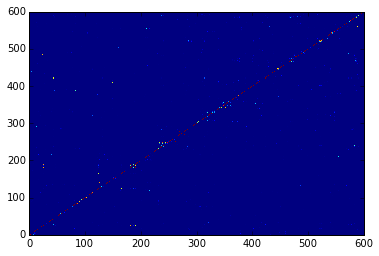

In [415]:
normedK = k - np.mean(k)
plt.pcolor(normedK)

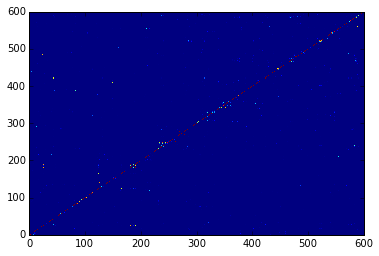

In [417]:
normedK = normedK/(np.max(np.max(k)) - np.min(np.min(k)))
plt.pcolor(normedK)